In [2]:
# Run in python console
import re
import os
import numpy as np
import pandas as pd
import random
import dill

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
import nltk; nltk.download('stopwords')
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pickle

from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.model_selection import CVScores

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Understanding how listing description influence price and listing rating

The AirBnb dataset provides with features not only that have numeric or structured values but also unstructured data. To mention a few examples: the name of of the property, a short description of the space, an overview of the neighborhood and a description of the listing itself. As part of our project we would like to use Natural Language Processing techniques to understand how unstructured data available for each listing might influence price.

The reason we believe that there might be a relationship betweeen the listing description and the price is because 
we think that what makes a listing valuable is not only their features per se but also the way the place is presented to the potential guest. This, not only includes the pictures of the listing but also the words that the listing owners pick to describe their listing and assumingly seeks to attrack their potential customers. We assume that by including certain words in the description could potentially increase the attractiveness of a certain property to be rented. Thus, due to supply and demand law, can assume that the more demanded a property is, the higher the value it could have. 

To begin with the analysis we want to see if there are similarities in the way listing owners describe their place and the price they charge per night. We proceed with the assumption that listings with similar features will use similar words to describe their property. Furthermore we are curious about how words in the description could inform us about the listing's overall rating.

For this reason we will be using this notebook to try to answer the following questions:

1. Do listings using similar words in their description share a similar price?
2. Do listings using similar words in their description share other features that are relevant to predict price?
3. Do listings using similar words in their description end up having similar guest acceptance/rating?

For this purpose we will first, use Latent Dirichlet Allocation to elicit the latent topics in the description. Latent Dirichlet Allocation is an unsupervised algorithm, largely used in Natural Language Processing to perform what is known as Topic Modeling. This algorightm uses probability distribution to discover which parts of the data are similar. In the context of our project we would try to discover the similar words used the description of New York City listings that could potentially influence price.

## Importing data into DataFrame

In [3]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df =  pd.read_csv(listings_csv,low_memory=False)

In [4]:
# Creating content column with name and description of property
listings_df['content'] = listings_df['name'] + listings_df['description']
content = listings_df[['id','content']]

As we will be able to see, the description is the single text field with fewer than 3% missing values. This is also one of the reasons why we chose to work with this field to experiment with NLP into trying to predict price.

In [5]:
summary_nulls = round((listings_df.summary.isnull().sum()/listings_df.shape[0])*100, 1)
space = round((listings_df.space.isnull().sum()/listings_df.shape[0])*100, 1)
description = round((listings_df.description.isnull().sum()/listings_df.shape[0])*100, 1)
neighborhood_overview = round((listings_df.neighborhood_overview.isnull().sum()/listings_df.shape[0])*100, 1)
notes = round((listings_df.notes.isnull().sum()/listings_df.shape[0])*100, 1)
transit = round((listings_df.transit.isnull().sum()/listings_df.shape[0])*100, 1)
access = round((listings_df.access.isnull().sum()/listings_df.shape[0])*100, 1)
interaction = round((listings_df.interaction.isnull().sum()/listings_df.shape[0])*100, 1)
house_rules = round((listings_df.house_rules.isnull().sum()/listings_df.shape[0])*100, 1)
name = round((listings_df.name.isnull().sum()/listings_df.shape[0])*100, 1)

In [6]:
print(f"{summary_nulls}% of listings have empty summaries")
print(f"{space}% of listings have empty space description")
print(f"{description}% of listings have empty description")
print(f"{neighborhood_overview}% of listings have empty overviews on their neighborhood")
print(f"{notes}% of listings have no notes from the host")
print(f"{transit}% of listings have no information on transit")
print(f"{access}% of listings have no information on accessibility")
print(f"{interaction}% of listings have no information on interaction")
print(f"{house_rules}% of listings have no information on house_rules")
print(f"{name}% of listings have no information on name")

4.8% of listings have empty summaries
28.0% of listings have empty space description
2.4% of listings have empty description
34.4% of listings have empty overviews on their neighborhood
59.6% of listings have no notes from the host
34.4% of listings have no information on transit
47.2% of listings have no information on accessibility
40.2% of listings have no information on interaction
39.1% of listings have no information on house_rules
0.0% of listings have no information on name


Importing numeric features from previous Exploratory Data Analysis and Modeling

In [7]:
# Importing model df
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [8]:
model_cols_df.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


In [9]:
# Joining the new created 'content' column with the model dataframe just to choose rows that are relevant
df_model = pd.merge(left=model_cols_df, right=content, how='left', on='id')

# dropping null values
df_model = df_model.dropna()

In [10]:
df_model.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## Predicting Language from content

As we may already know, AirBnb is a platform used by people from all around the world. Therefore, some hosts that want to attract guests who speak languages other than English might want to use different language or languages to describe their place. For our analysis we want to make sure that we are working with a single language and since the majority of reviews are written in English, we will use langdetect, to determine those descriptions written in English only. Langdetect is a language detection algorithm that supports 55 languages out of the box. To maximize the probability of the algorithms predicting the correct language we make sure we send it a long enough string.

In [11]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [12]:
df_model['content_lang'] = df_model.content.apply(lambda x: predict_lang(x))

In [13]:
# getting only text in English
df_model_en_desc = df_model[df_model.content_lang=='en']

In [14]:
df_model.shape, df_model_en_desc.shape

((27354, 47), (27107, 47))

In [15]:
df_model_en_desc.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## LDA for Topic Modeling in Listing Description

In [16]:
def generate_list_content(df):
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [17]:
lst_texts = generate_list_content(df_model_en_desc)

In [18]:
len(lst_texts)

27107

## Tokenize words and clean up text

In [19]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [22]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [28]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

The biggest challenge of using LDA for Topic Modeling is determining the right amount of topics *n*. Therefore we will use two metrics: Perplexity and Coherence as well as the pyLDAvis to approximately determine the right number of topics that are latent in our corpus (description).

## Build list of topic models

In [29]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

# num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# num_topics = [2,3,4,5,6,7,8,9]
num_topics = [5,7,9]
models = build_topics(num_topics)

## Compute Model Perplexity and Coherence Score for all models

According to (Jansen, 2018) "Perplexity when applied to LDA meassures how well the topic-word probability distribution recovered by the model predicts a sample, for example, unseen text documents. It is based on the entropy H(p) of this distribution p and computed with respect to the set of tokens w. Measures closer to zero imply the distribution is better at predicting the sample".

In terms of Coherence, we will be using Gensim implementation based on the paper writen by (Roder, et al., 2015). Larger scores in coherence mean better topic representation of the corpus.

## Bibliography

Jansen, S. (2018). Perplexity. In Hands-on machine learning for algorithmic trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Birmingham: Packt Publishing.

Roder, M., Both, A., and Hinneburg, A. (2015). Exploring the Space of Topic Coherence Measures. In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining, WSDM ’15, pages 399–408, New York, NY, USA. ACM.

In [33]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [34]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.718921,0.479423,5
1,-6.761145,0.493251,7
2,-6.854128,0.436776,9


## Graphic of number of Topics and Perplexity

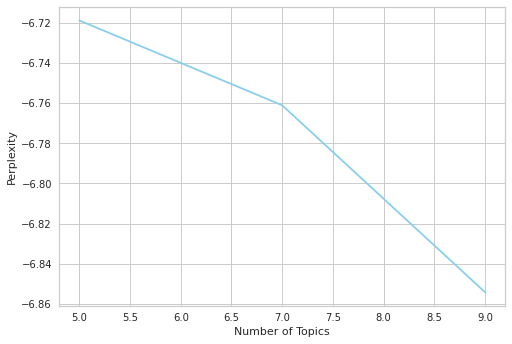

In [35]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

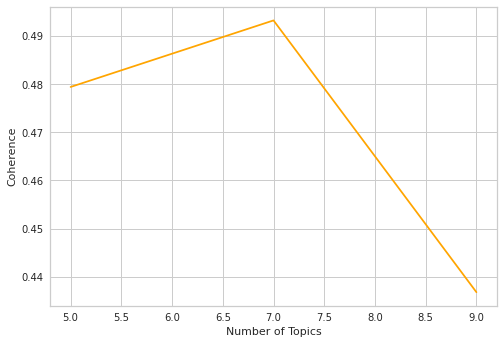

In [36]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Visualizing topics according to the best *n*

### Visualization with 5 topics

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(models[0], corpus, id2word, sort_topics=False)
vis_5

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      19.012032        1       1  0.164491 -0.111883
1      30.813936        1       2 -0.181557  0.217989
2      18.020292        1       3 -0.182235 -0.280601
3      14.474405        1       4 -0.070521  0.118224
4      17.679335        1       5  0.269822  0.056271, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
99    Default  43251.000000          room  43251.000000  30.0000  30.0000
96    Default  20971.000000       private  20971.000000  29.0000  29.0000
8     Default  19237.000000           bed  19237.000000  28.0000  28.0000
141   Default  19582.000000          walk  19582.000000  27.0000  27.0000
93    Default  18203.000000        minute  18203.000000  26.0000  26.0000
289   Default  12158.000000          stay  12158.000000  25.0000  25.0000
106   Default  19046.000000         train  19046.000000  24.0000  24.0000
218   Default  16654.000000    restaurant  16654.000000  23.0000  23.0000
63    Default  28275.000000       bedroom  28275.000000  22.0000  22.0000
182   Default  11152.000000         share  11152.000000  21.0000  21.0000
87    Default  16204.000000         guest  16204.000000  20.0000  20.0000
198   Default  13840.000000          away  13840.000000  19.0000  19.0000
131   Default   8043.000000         queen   8043.000000  18.0000  18.0000
20    Default  12532.000000          full  12532.000000  17.0000  17.0000
62    Default  14302.000000      bathroom  14302.000000  16.0000  16.0000
64    Default  11727.000000         block  11727.000000  15.0000  15.0000
309   Default  12195.000000          home  12195.000000  14.0000  14.0000
127   Default  10833.000000        living  10833.000000  13.0000  13.0000
134   Default   7497.000000          size   7497.000000  12.0000  12.0000
137   Default  11033.000000        subway  11033.000000  11.0000  11.0000
126   Default   9726.000000          live   9726.000000  10.0000  10.0000
202   Default  10216.000000         close  10216.000000   9.0000   9.0000
28    Default  11717.000000       kitchen  11717.000000   8.0000   8.0000
110   Default  44233.000000     apartment  44233.000000   7.0000   7.0000
228   Default   9519.000000           bar   9519.000000   6.0000   6.0000
185   Default  16339.000000         space  16339.000000   5.0000   5.0000
249   Default  12698.000000  neighborhood  12698.000000   4.0000   4.0000
19    Default  11483.000000         floor  11483.000000   3.0000   3.0000
4     Default  12598.000000          area  12598.000000   2.0000   2.0000
136   Default   8012.000000       station   8012.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
406    Topic5    998.412292        pillow    999.295349   1.7319  -5.7583
613    Topic5    991.587036        washer    992.476990   1.7319  -5.7652
787    Topic5    996.231140          iron    997.126038   1.7319  -5.7605
217    Topic5    964.460754  refrigerator    965.344788   1.7319  -5.7929
911    Topic5    925.479431       heating    926.375366   1.7318  -5.8342
8      Topic5  19198.929688           bed  19237.572266   1.7308  -2.8019
21     Topic5   1871.798950       furnish   1875.035767   1.7310  -5.1298
394    Topic5   2137.843262         couch   2198.813232   1.7047  -4.9969
239    Topic5   5411.050781         fully   6206.628906   1.5956  -4.0683
158    Topic5   5711.213867       include   6649.898438   1.5806  -4.0143
71     Topic5   1451.779175        double   1500.652588   1.6997  -5.3840
623    Topic5   3246.926025         brand   3738.270508   1.5919  -4.5790
20     Topic5   8942.408203          full  12532.113281   1.3953  -3.5659
55     Topic5   3694.222412         towel   4608.339844   1.5117  -4.4500
236    Topic5   3824.394775         equip   4817.586914   1.5019  -4.4153
135    Topic5   3004.338135

In [38]:
pyLDAvis.save_html(vis_5, '../data/visualization_5_topics.html')

### Visualization with 7 topics

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_7 = pyLDAvis.gensim.prepare(models[1], corpus, id2word, sort_topics=False)
vis_7

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       9.413794        1       1  0.075714  0.298152
1      13.365075        1       2 -0.221976 -0.185263
2      19.688677        1       3  0.057813  0.117825
3       2.475911        1       4  0.318279 -0.085613
4       5.778956        1       5  0.134920 -0.244975
5      23.247063        1       6 -0.136154  0.136533
6      26.030523        1       7 -0.228596 -0.036660, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
99    Default  41516.000000            room  41516.000000  30.0000  30.0000
63    Default  30419.000000         bedroom  30419.000000  29.0000  29.0000
96    Default  20578.000000         private  20578.000000  28.0000  28.0000
289   Default  12348.000000            stay  12348.000000  27.0000  27.0000
8     Default  20832.000000             bed  20832.000000  26.0000  26.0000
141   Default  19706.000000            walk  19706.000000  25.0000  25.0000
110   Default  46508.000000       apartment  46508.000000  24.0000  24.0000
182   Default  10705.000000           share  10705.000000  23.0000  23.0000
93    Default  18319.000000          minute  18319.000000  22.0000  22.0000
106   Default  19162.000000           train  19162.000000  21.0000  21.0000
218   Default  16760.000000      restaurant  16760.000000  20.0000  20.0000
62    Default  14319.000000        bathroom  14319.000000  19.0000  19.0000
20    Default  13454.000000            full  13454.000000  18.0000  18.0000
198   Default  13928.000000            away  13928.000000  17.0000  17.0000
87    Default  16326.000000           guest  16326.000000  16.0000  16.0000
127   Default  10827.000000          living  10827.000000  15.0000  15.0000
185   Default  16314.000000           space  16314.000000  14.0000  14.0000
239   Default   5868.000000           fully   5868.000000  13.0000  13.0000
129   Default   8055.000000             new   8055.000000  12.0000  12.0000
64    Default  11801.000000           block  11801.000000  11.0000  11.0000
381   Default   5525.000000         provide   5525.000000  10.0000  10.0000
137   Default  11104.000000          subway  11104.000000   9.0000   9.0000
117   Default   7066.000000          coffee   7066.000000   8.0000   8.0000
309   Default  12047.000000            home  12047.000000   7.0000   7.0000
202   Default  10281.000000           close  10281.000000   6.0000   6.0000
236   Default   4584.000000           equip   4584.000000   5.0000   5.0000
113   Default   7068.000000        building   7068.000000   4.0000   4.0000
249   Default  12624.000000    neighborhood  12624.000000   3.0000   3.0000
228   Default   9580.000000             bar   9580.000000   2.0000   2.0000
19    Default  11674.000000           floor  11674.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
345    Topic7   4263.884766             min   4264.813477   1.3457  -4.6934
258    Topic7   3923.269531            stop   3924.197998   1.3457  -4.7767
346    Topic7   3062.156006          nearby   3063.085693   1.3456  -5.0245
570    Topic7   3041.583740        downtown   3042.512939   1.3456  -5.0312
840    Topic7   2905.318115         parking   2906.247559   1.3456  -5.0771
705    Topic7   2584.728516     supermarket   2585.656738   1.3455  -5.1940
568    Topic7   2575.067871      convenient   2575.997803   1.3455  -5.1977
747    Topic7   2488.659668          corner   2489.588623   1.3455  -5.2319
712    Topic7   2433.125000         grocery   2434.053711   1.3455  -5.2544
316    Topic7   2358.459473            ride   2359.388184   1.3455  -5.2856
634    Topic7   2355.130371        shopping   2356.059082   1.3455  -5.2870
223    Topic7   2014.388794  transportation   2015.318115   1.3454  -5.4433
1187   Topic7   2010.848755            call   2011.

In [40]:
pyLDAvis.save_html(vis_7, '../data/visualization_7_topics.html')

### Visualization with 9 topics 

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_9 = pyLDAvis.gensim.prepare(models[2], corpus, id2word, sort_topics=False)
vis_9

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       1.123340        1       1  0.265878  0.089997
1       8.419502        1       2  0.002724 -0.019008
2       6.580731        1       3  0.072509  0.231309
3      18.879490        1       4 -0.209602  0.151448
4       1.070564        1       5  0.286701 -0.009144
5      24.353514        1       6 -0.173589  0.152167
6       9.701756        1       7 -0.072399 -0.253910
7      24.347334        1       8 -0.228926 -0.074187
8       5.523763        1       9  0.056704 -0.268671, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
99    Default  40445.000000        room  40445.000000  30.0000  30.0000
87    Default  15948.000000       guest  15948.000000  29.0000  29.0000
63    Default  28812.000000     bedroom  28812.000000  28.0000  28.0000
96    Default  20047.000000     private  20047.000000  27.0000  27.0000
19    Default  12638.000000       floor  12638.000000  26.0000  26.0000
141   Default  19796.000000        walk  19796.000000  25.0000  25.0000
106   Default  19244.000000       train  19244.000000  24.0000  24.0000
289   Default  12608.000000        stay  12608.000000  23.0000  23.0000
93    Default  18403.000000      minute  18403.000000  22.0000  22.0000
218   Default  16836.000000  restaurant  16836.000000  21.0000  21.0000
8     Default  19784.000000         bed  19784.000000  20.0000  20.0000
182   Default  10328.000000       share  10328.000000  19.0000  19.0000
110   Default  45553.000000   apartment  45553.000000  18.0000  18.0000
198   Default  13992.000000        away  13992.000000  17.0000  17.0000
62    Default  13825.000000    bathroom  13825.000000  16.0000  16.0000
366   Default   8733.000000       clean   8733.000000  15.0000  15.0000
64    Default  11855.000000       block  11855.000000  14.0000  14.0000
137   Default  11154.000000      subway  11154.000000  13.0000  13.0000
20    Default  12744.000000        full  12744.000000  12.0000  12.0000
202   Default  10328.000000       close  10328.000000  11.0000  11.0000
6     Default  12436.000000   available  12436.000000  10.0000  10.0000
28    Default  11771.000000     kitchen  11771.000000   9.0000   9.0000
228   Default   9627.000000         bar   9627.000000   8.0000   8.0000
139   Default   7925.000000        time   7925.000000   7.0000   7.0000
127   Default  10747.000000      living  10747.000000   6.0000   6.0000
309   Default  12220.000000        home  12220.000000   5.0000   5.0000
37    Default   6068.000000      modern   6068.000000   4.0000   4.0000
175   Default  10163.000000       place  10163.000000   3.0000   3.0000
31    Default  14651.000000      locate  14651.000000   2.0000   2.0000
381   Default   5709.000000     provide   5709.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
82     Topic9    786.563782      flight    787.514404   2.8949  -4.8335
478    Topic9    733.888184   townhouse    734.838623   2.8948  -4.9028
1279   Topic9    683.355408       spend    684.306213   2.8947  -4.9741
70     Topic9    675.600830     consist    676.552002   2.8947  -4.9856
480    Topic9    620.634216    upstairs    621.584839   2.8946  -5.0704
102    Topic9    617.617859       slope    618.568481   2.8946  -5.0753
355    Topic9    610.335266       story    611.285828   2.8946  -5.0871
528    Topic9    598.770569       third    599.721252   2.8945  -5.1063
791    Topic9    581.250916    original    582.201599   2.8945  -5.1360
567    Topic9    557.921814     classic    558.872437   2.8944  -5.1769
2679   Topic9    505.415405       class    506.366852   2.8942  -5.2758
814    Topic9    480.187653        deck    481.138245   2.8941  -5.3270
95     Topic9    464.152924      occupy    465.103760   2.8941  -5.3609
732    Topic9    459.755188       suite    460.7059

In [42]:
pyLDAvis.save_html(vis_9, '../data/visualization_9_topics.html')

## Creating DataFrame with scores and topics for 5 topics

In [43]:
# function that returns data frame with 
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
#     df_model_en_desc.reset_index(inplace=True)
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
    sent_topics_df = pd.concat([df_model_en_desc['id'],sent_topics_df], axis=1)
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [44]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[0], corpus=corpus, texts=lst_texts)

In [45]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5
0,2595.0,"(4, 0.4838705)","(3, 0.33420482)","(1, 0.118685775)","(0, 0.04238241)","(2, 0.020856503)"
1,3831.0,"(0, 0.2983149)","(3, 0.29012448)","(4, 0.16767113)","(1, 0.15698999)","(2, 0.08689951)"
2,5099.0,"(4, 0.3152245)","(1, 0.3117018)","(0, 0.21717972)","(3, 0.12931941)","(2, 0.026574563)"
3,5121.0,"(2, 0.5688717)","(0, 0.1980907)","(3, 0.1107369)","(1, 0.07599128)","(4, 0.046309397)"
4,5178.0,"(4, 0.34072736)","(0, 0.22131321)","(2, 0.21041492)","(1, 0.20925465)","(3, 0.01828987)"


In [46]:
sent_topics_df.shape

(27856, 6)

In [47]:
sent_topics_df = sent_topics_df.dropna()

In [48]:
sent_topics_df.shape

(26358, 6)

### Separating the Topic from its score

In [49]:
for i in range(1,df_n_cols):
    top_col = 'topic' + str(i)
    score_col = 'score_dom_topic_' + str(i)
    sent_topics_df[top_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[0]
    sent_topics_df[score_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [50]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
0,2595.0,"(4, 0.4838705)","(3, 0.33420482)","(1, 0.118685775)","(0, 0.04238241)","(2, 0.020856503)",4,0.483871,3,0.334205,1,0.118686,0,0.042382,2,0.020857
1,3831.0,"(0, 0.2983149)","(3, 0.29012448)","(4, 0.16767113)","(1, 0.15698999)","(2, 0.08689951)",0,0.298315,3,0.290124,4,0.167671,1,0.156990,2,0.086900
2,5099.0,"(4, 0.3152245)","(1, 0.3117018)","(0, 0.21717972)","(3, 0.12931941)","(2, 0.026574563)",4,0.315224,1,0.311702,0,0.217180,3,0.129319,2,0.026575
3,5121.0,"(2, 0.5688717)","(0, 0.1980907)","(3, 0.1107369)","(1, 0.07599128)","(4, 0.046309397)",2,0.568872,0,0.198091,3,0.110737,1,0.075991,4,0.046309
4,5178.0,"(4, 0.34072736)","(0, 0.22131321)","(2, 0.21041492)","(1, 0.20925465)","(3, 0.01828987)",4,0.340727,0,0.221313,2,0.210415,1,0.209255,3,0.018290


In [51]:
# Dropping columns with tuples
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [52]:
sent_topics_df.head()

,id,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
0,2595.0,4,0.483871,3,0.334205,1,0.118686,0,0.042382,2,0.020857
1,3831.0,0,0.298315,3,0.290124,4,0.167671,1,0.156990,2,0.086900
2,5099.0,4,0.315224,1,0.311702,0,0.217180,3,0.129319,2,0.026575
3,5121.0,2,0.568872,0,0.198091,3,0.110737,1,0.075991,4,0.046309
4,5178.0,4,0.340727,0,0.221313,2,0.210415,1,0.209255,3,0.018290


In [53]:
# Formatting DataFrame
sent_topics_df.rename(columns={"topic1": "winner_topic",
                               "score_dom_topic_1":"winner_topic_score",
                               "topic2": "second_place_topic",
                               "score_dom_topic_2":"second_topic_score",
                               "topic3": "third_place_topic",
                               "score_dom_topic_3":"third_topic_score",
                               "topic4": "fourth_place_topic",
                               "score_dom_topic_4":"fourth_topic_score",
                              "topic5": "fifth_place_topic",
                               "score_dom_topic_5":"fifth_topic_score"},inplace=True)

In [134]:
sent_topics_df.winner_topic.value_counts()

1    13914
4     3814
0     3402
2     3101
3     2127
Name: winner_topic, dtype: int64

## Modeling

In [55]:
# Merging the initial DataFrame with features with the topics DataFrame
df_model_en_desc_merged = pd.merge(left=df_model_en_desc, right=sent_topics_df, how='left', on='id')

In [56]:
df_model_en_desc_merged.iloc[:,0:6].head()

,id,host_since,host_is_superhost,host_identity_verified,is_location_exact,accommodates
0,2595,733294,0,1,0,2
1,3831,733383,0,1,1,3
2,5099,733440,0,0,0,2
3,5121,733441,0,0,0,2
4,5178,733469,0,0,1,2


In [57]:
df_model_en_desc_merged.shape

(27107, 57)

In [58]:
df_model_en_desc_merged = df_model_en_desc_merged.dropna()

In [59]:
df_model_en_desc_merged.shape

(26358, 57)

### Understanding the topic that appears as winner the most

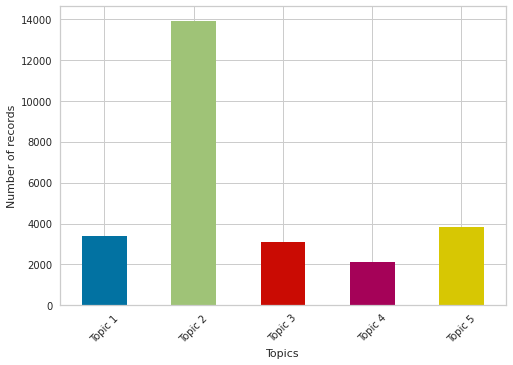

In [60]:
fig, ax = plt.subplots()
df = df_model_en_desc_merged.groupby('winner_topic').size().plot(kind='bar', x='topics', ax=ax)
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Topic 1'
labels[1] = 'Topic 2'
labels[2] = 'Topic 3'
labels[3] = 'Topic 4'
labels[4] = 'Topic 5'

ax.set_xticklabels(labels,rotation='45')
ax.set(xlabel='Topics', ylabel='Number of records')

plt.show()

The above plot si a representation of the distribution of the topics as the first option for each docuement.

at this plot we can conclude tha the topic that appear to be more latent in the corpus is the green bar that corresponds to topic 2 and the less prevalent is topic4. Let's now take a more thorough look at the words that are in each topic to have a better understanding of wht might be happening.

### Word Clouds

In [61]:
num_topics = 5
topic_words = []
for i in range(num_topics):
    tt = models[0].get_topic_terms(i,20)
    topic_words.append([id2word[pair[0]] for pair in tt])

In [62]:
models[0].show_topic(0)

[('room', 0.12714744),
 ('private', 0.061474007),
 ('bedroom', 0.04003942),
 ('share', 0.032783277),
 ('bathroom', 0.03147211),
 ('living', 0.026645858),
 ('live', 0.024994813),
 ('space', 0.02370753),
 ('area', 0.022565633),
 ('kitchen', 0.018961934)]

In [63]:
df_top_30_n_5 = pd.DataFrame.from_records(topic_words)
df_top_30_n_5 = df_top_30_n_5.T

In [64]:
df_top_30_n_5.rename(columns={0: "Topic 1", 1: "Topic 2",
                              2: "Topic 3", 3: "Topic 4",
                              4: "Topic 5"}, inplace=True)

In [65]:
df_top_30_n_5

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,room,apartment,stay,apartment,bed
1,private,walk,guest,floor,bedroom
2,bedroom,train,home,modern,apartment
3,share,minute,need,light,full
4,bathroom,restaurant,place,home,queen
5,living,away,time,beautiful,size
6,live,block,clean,view,include
7,space,neighborhood,space,space,fully
8,area,subway,make,enjoy,kitchen
9,kitchen,locate,check,perfect,new


In [66]:
top_0 = models[0].show_topic(0, 30)
top_1 = models[0].show_topic(1, 30)
top_2 = models[0].show_topic(2, 30)
top_3 = models[0].show_topic(3, 30)
top_4 = models[0].show_topic(4, 30)

In [67]:
def listtodict(A, di):
    di = dict(A)
    return di 

di_wc_0 = listtodict(top_0,{})
di_wc_1 = listtodict(top_1,{})
di_wc_2 = listtodict(top_2,{})
di_wc_3 = listtodict(top_3,{})
di_wc_4 = listtodict(top_4,{})

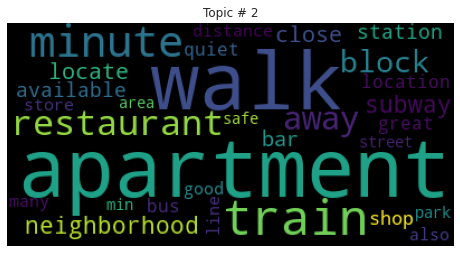

In [68]:
plt.figure()
plt.imshow(WordCloud().fit_words(di_wc_1))
plt.axis("off")
plt.title("Topic # 2")
plt.show()

It seems that Topic 2 has words related to location, for example: walk, train, neighborhood, block, close. This may lead to conclude that the majority of hosts recognize the importance of including such words into their description to attract guests. However, lets see if these words are actually influencing price. For this purpose we will try to understand the importance of each one of these topics' scores in our regression problem. We assume that the larger the impact of the score of each topic in the corpus, the most important to determine its price.

### Creating features X

In [69]:
X = df_model_en_desc_merged.iloc[:, 1:]
X = X.loc[:, X.columns != 'price']
X = X.loc[:, X.columns != 'content']
X = X.loc[:, X.columns != 'content_lang']

### Creating target y

In [70]:
y = df_model_en_desc_merged.price

### Cross validation with multiple regressors

In [71]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

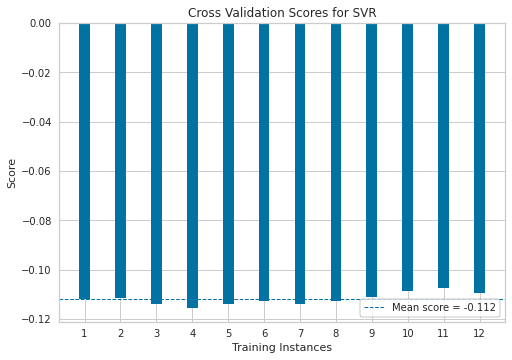

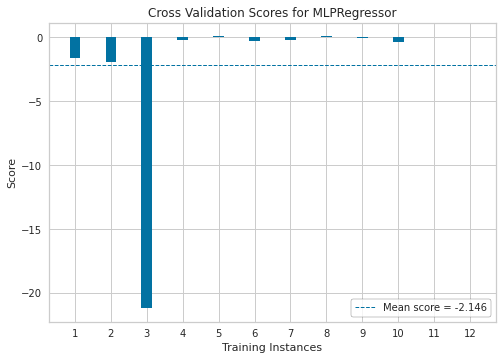

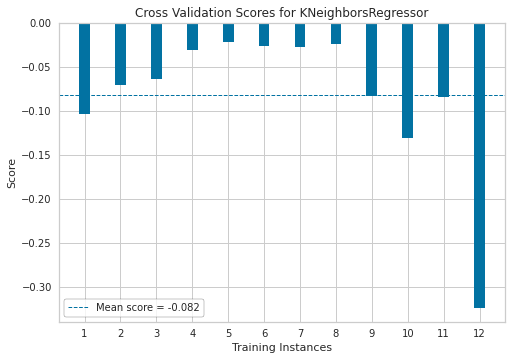

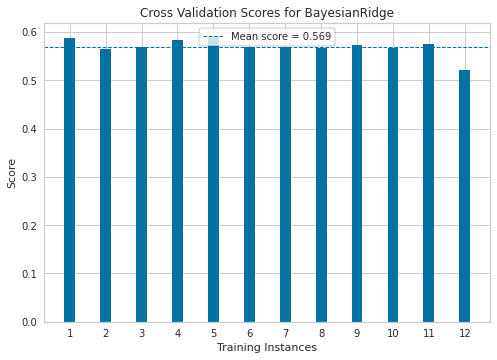

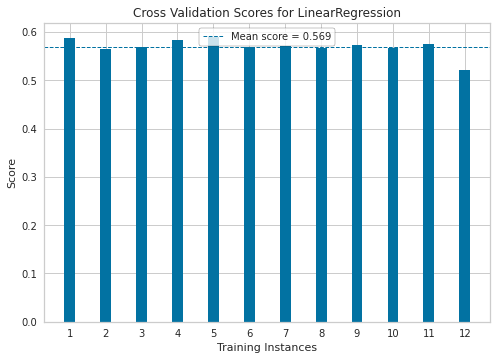

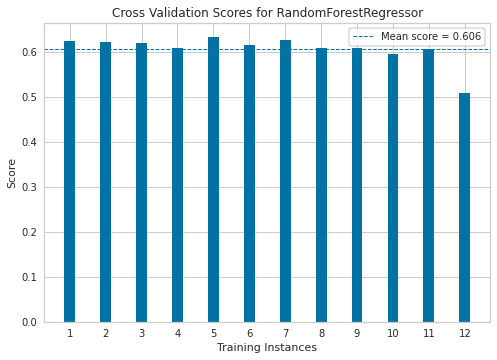

In [100]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = CVScores(regressor, cv=cv)
    visualizer.fit(X, y)
    visualizer.show()

## Residuals for multiple regression models

### Split train - test sets

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

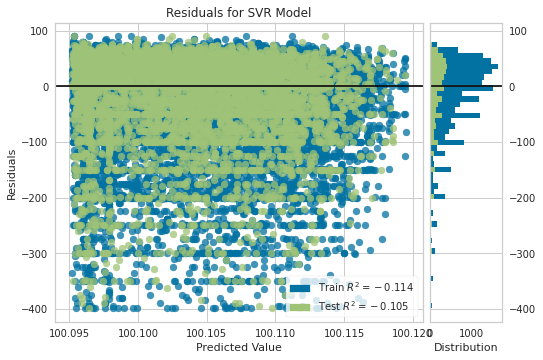

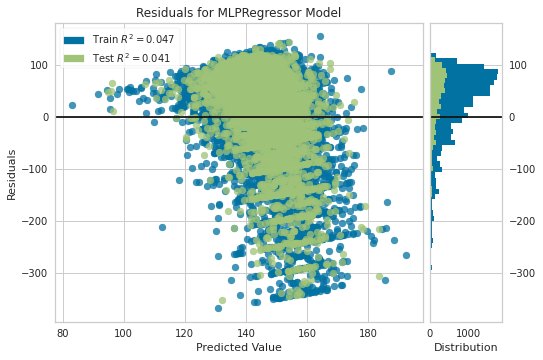

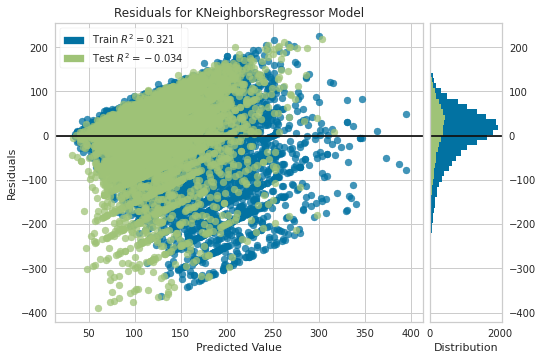

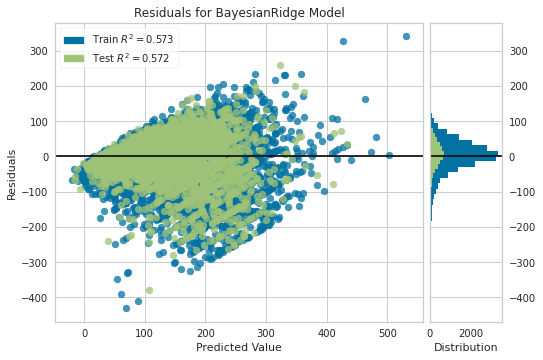

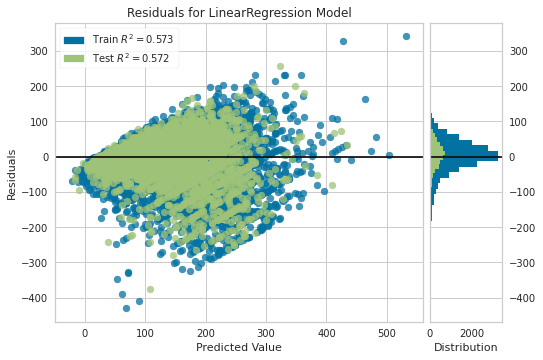

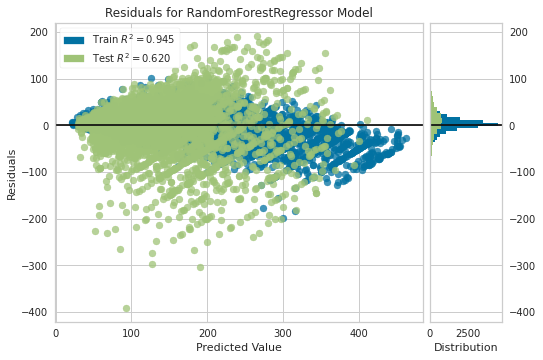

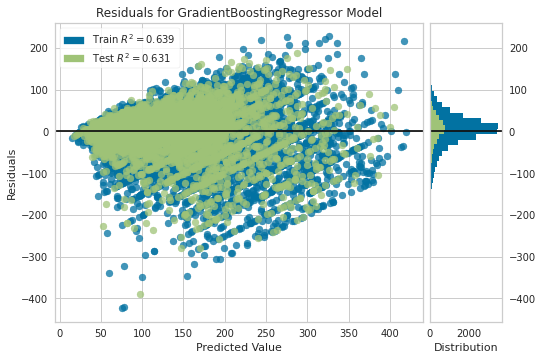

In [102]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
    "gradient boost regressor": GradientBoostingRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

After analyzing the average score in cross validations together with the residuals, we can continue to conclude that our baseline model is still the Random Forest Regressor. This excercise was fundamental to see that despite the addition of information about the description, this continues to be true. We will now continue doing some more experimentation.

## Experimenting with the baseline model using the Random Forest Regressor

Random Forest algorithms are ensemble methods of decision trees generated on a random split of a determined data set.The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In the case of regression, the average of all the tree outputs is considered as the final result. Source: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [108]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')
features.append('random_variable')

In [109]:
X_train.head()

,host_since,host_is_superhost,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,guests_included,number_of_reviews,...,winner_topic_score,second_place_topic,second_topic_score,third_place_topic,third_topic_score,fourth_place_topic,fourth_topic_score,fifth_place_topic,fifth_topic_score,random cont variable
25358,737168,0,0,0,2,1.0,1.0,1.0,1,1,...,0.355121,2.0,0.229755,3.0,0.157218,0.0,0.131858,4.0,0.126048,0.161196
22842,736257,1,0,1,2,1.0,1.0,1.0,1,15,...,0.478733,2.0,0.243743,0.0,0.102399,3.0,0.089564,4.0,0.085560,0.634966
25252,736088,0,0,1,2,1.0,1.0,1.0,1,2,...,0.322713,2.0,0.256497,4.0,0.163138,3.0,0.139718,1.0,0.117934,0.546370
18955,736826,0,0,1,4,1.0,2.0,1.0,3,2,...,0.391716,3.0,0.382623,0.0,0.103967,2.0,0.068457,4.0,0.053237,0.812956
17135,737066,0,0,0,6,1.0,1.0,1.0,1,50,...,0.676543,0.0,0.101502,2.0,0.085324,3.0,0.073458,4.0,0.063172,0.607817


In [110]:
# making sure that the number of columns match with the features
X_train.shape, len(features), y_train.shape

((21086, 54), 54, (21086,))

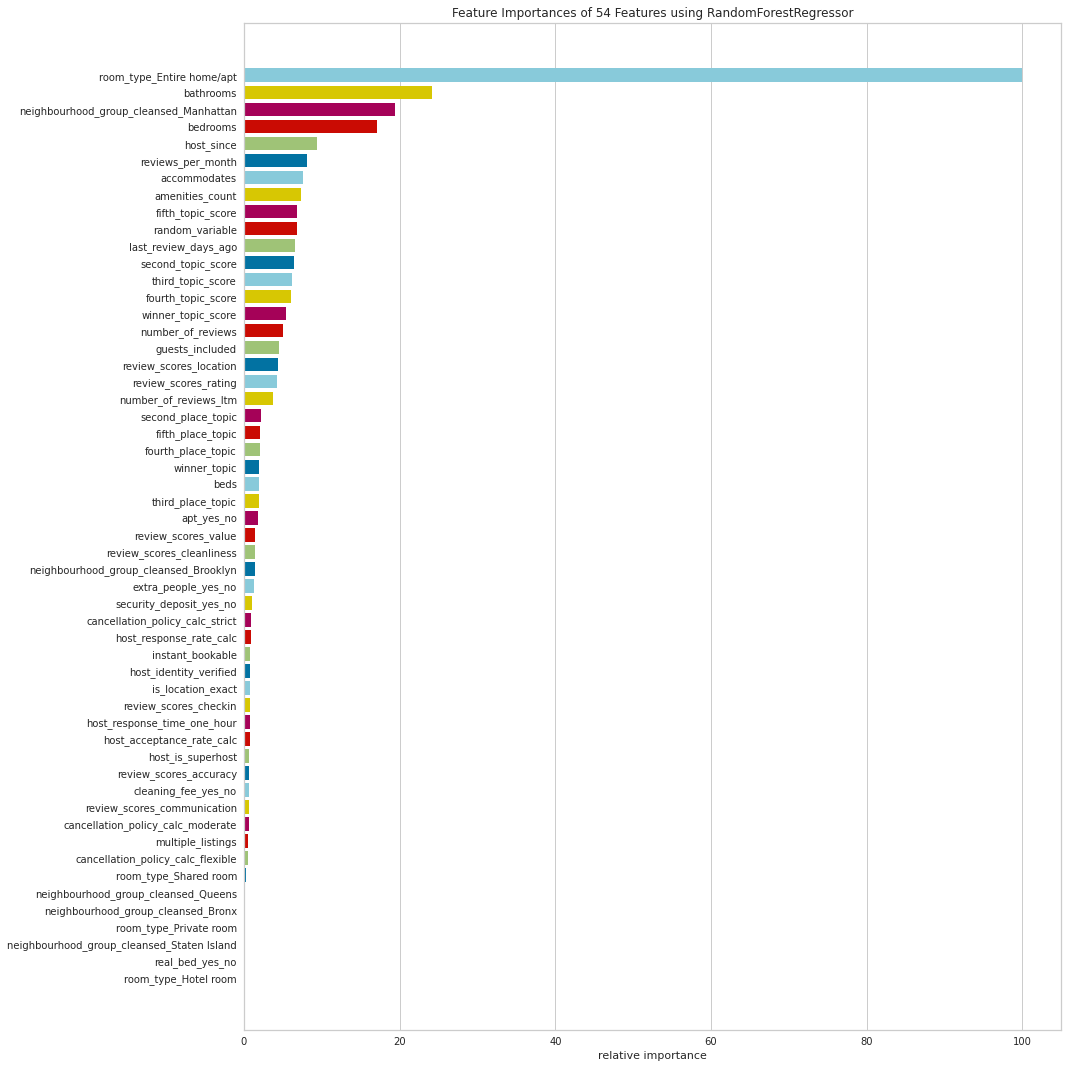

In [111]:
# Most important features
viz = FeatureImportances(regressors['random forest'], labels=features, size=(1080, 1080))
viz.fit(X_train, y_train)
viz.show()

### Creating a random variable 

As we can see in the feature importance graphic above we could conclude that the topics are part of the top features to determine price. To discard the fact that the impact of the scores is due to the fact that the values are numbers from a continuous distribution of numbers, we will create new column with random values from 0 to 1 and run the base regression again. In case this random doesn't appear as part of the next list of most relevant ones, we can be sure to discard this potential challenge

In [112]:
rand_var = list()
for i in range(X.shape[0]):
    rand_var.append(random.uniform(0, 1))

In [113]:
X['random cont variable'] = rand_var

In [114]:
X.shape

(26358, 54)

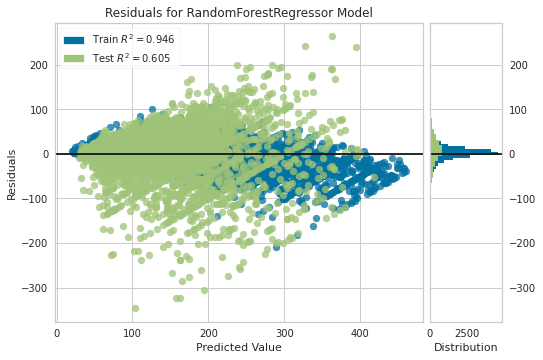

In [115]:
X_w_rand_train, X_w_rand_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_2 = ResidualsPlot(RandomForestRegressor())
visualizer_2.fit(X_w_rand_train, y_train)
visualizer_2.score(X_w_rand_test, y_test)
visualizer_2.show()

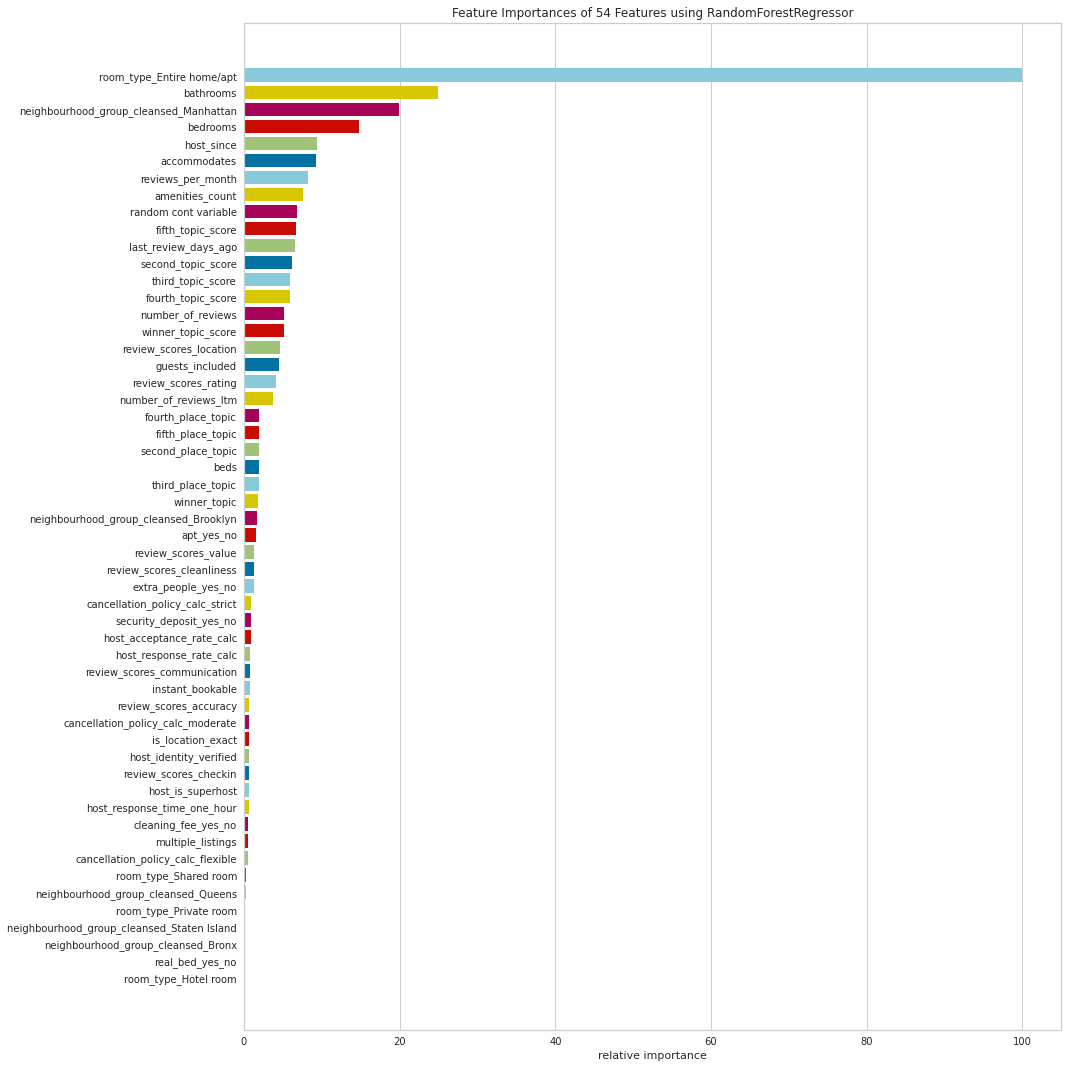

In [116]:
# Most important features
features_w_rand = features.append('random variable')
viz = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1080, 1080))
viz.fit(X_w_rand_train, y_train)
viz.show()

In [117]:
# X['neighbourhood_group_cleansed_Manhattan'].value_counts()
# X['neighbourhood_group_cleansed_Brooklyn'].value_counts()
# X['host_since'].value_counts()
# X['last_review_days_ago'].value_counts()

In [118]:
# X.columns

### Running the ensemble base model Random Forest removing room_type_Entire home/apt

In [119]:
X_not_prop_type = X.loc[:, X.columns != 'room_type_Entire home/apt']

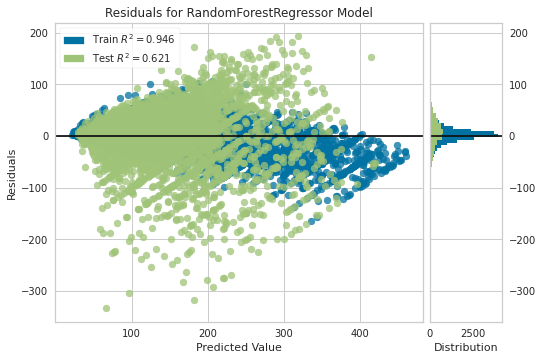

In [120]:
X_not_prop_type_train, X_not_prop_test, y_train, y_test = train_test_split(X_not_prop_type, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_3 = ResidualsPlot(RandomForestRegressor())
visualizer_3.fit(X_not_prop_type_train, y_train)
visualizer_3.score(X_not_prop_test, y_test)
visualizer_3.show()

In [121]:
# Most important features
features_not_property_typ = features.remove('room_type_Entire home/apt')

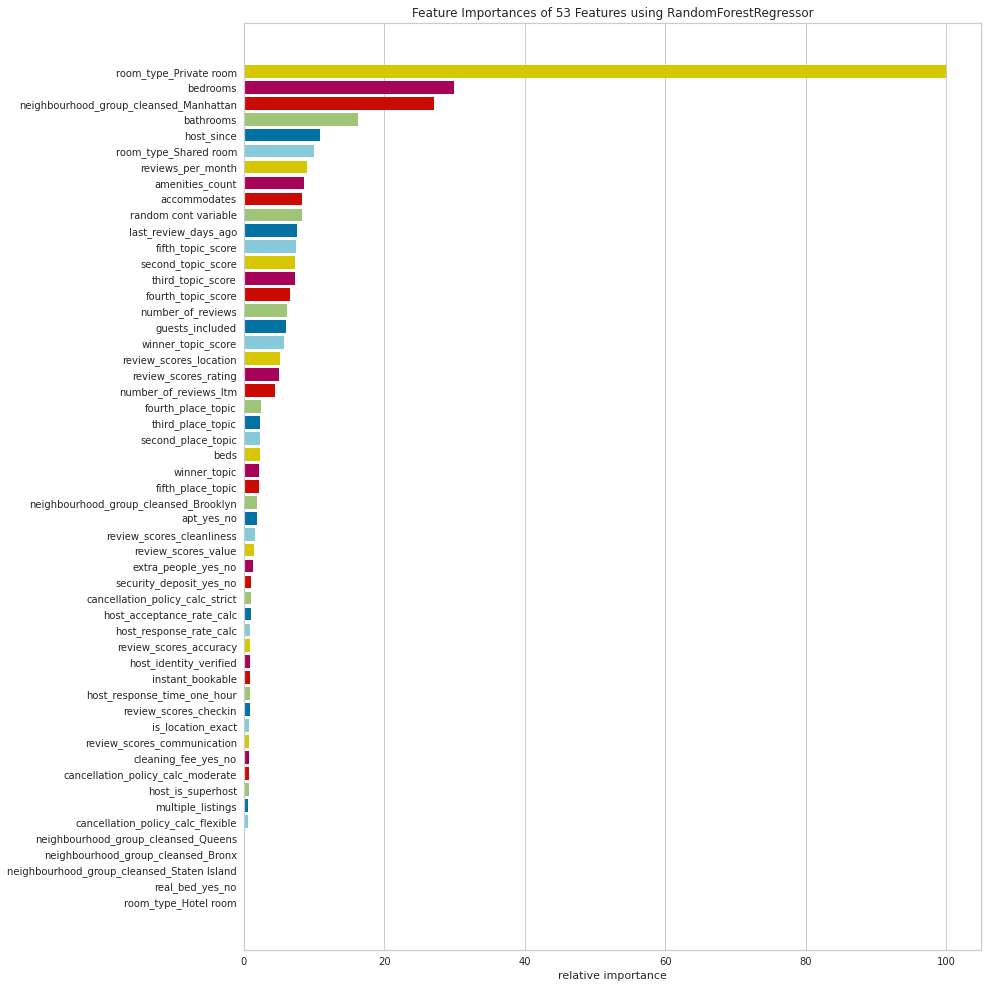

In [122]:
viz_3 = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1000, 1000))
viz_3.fit(X_not_prop_type_train, y_train)
viz_3.show()

### Determining linearity between room type entire home/apt

In [123]:
df_col = pd.DataFrame()
df_col['room type'] = X['room_type_Entire home/apt']
df_col['price'] = y

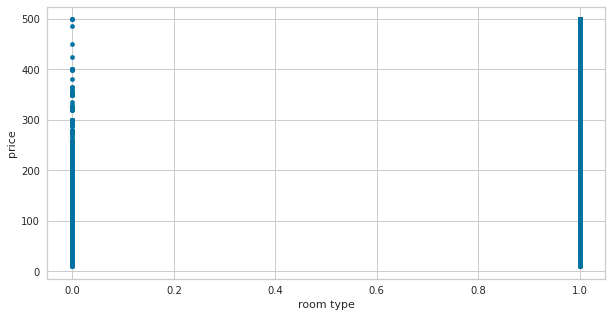

In [124]:
df_col.plot(kind='scatter', x='room type', y='price', figsize=(10,5), grid=True)
# X.plot(kind='scatter', x=X['room_type_Entire home/apt'], y=y, figsize=(10,5), grid=True)